In [5]:
import pandas as pd
import numpy as np
import replicaEVSE.load_curve as sim
import replicaEVSE.datautils as simdu
import os
import joblib
import dask.dataframe as dd
from tqdm import tqdm
from datetime import datetime, timedelta

%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

datadir = '../../data/'
mode = 'PRIVATE_AUTO'
test = False

# Dev the precompute of stop time. 

 - it must be run on a single person on a single day. can use groupby or use forloops
   - these are equivalent but the groupby is faster. 
   - there is a faster way to do with `df.shift()` but untested. 
 - there are negative and positive days. 
    - negative days are due to some glitch in replica where a trip ends after the next one begins. 
    - positive days are due to a trip ending past midnight. could just subtract a day from these  


In [2]:
# read in data and filter for mode
merged_df = pd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips_sorted_county.parquet'))

example of a trip ending after the next trip is supposed to start. 

In [63]:
cols = ['person_id', 'mode', 'weekday', 'start_time', 'end_time',]
merged_df[merged_df['person_id'] == '10235640618012933224'][cols]

,person_id,mode,weekday,start_time,end_time
14758,10235640618012933224,PRIVATE_AUTO,thursday,0 days 03:40:54,0 days 05:01:52
14759,10235640618012933224,PRIVATE_AUTO,thursday,0 days 04:05:17,0 days 04:22:16
14760,10235640618012933224,CARPOOL,saturday,0 days 08:21:38,0 days 08:31:54
14761,10235640618012933224,PRIVATE_AUTO,saturday,0 days 08:43:48,0 days 08:55:42
14762,10235640618012933224,PRIVATE_AUTO,thursday,0 days 14:10:24,0 days 15:25:23


run on a subset of the data

In [74]:
df = merged_df.loc[merged_df['mode'] == mode]
df = df.head(100000)


In [75]:
groups = df.sort_values(by=['person_id', 'weekday', 'start_time']).groupby(['person_id', 'weekday'])
outlist = joblib.Parallel(verbose=1, n_jobs=60)(joblib.delayed(simdu.calculate_stop_duration)(group) for name, group in groups)

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.


[Parallel(n_jobs=60)]: Done  81 tasks      | elapsed:    3.5s
[Parallel(n_jobs=60)]: Done 676 tasks      | elapsed:    4.2s
[Parallel(n_jobs=60)]: Done 2064 tasks      | elapsed:    4.9s
[Parallel(n_jobs=60)]: Done 3864 tasks      | elapsed:    6.1s
[Parallel(n_jobs=60)]: Done 9436 tasks      | elapsed:    8.5s
[Parallel(n_jobs=60)]: Done 19836 tasks      | elapsed:   12.9s
[Parallel(n_jobs=60)]: Done 30621 tasks      | elapsed:   17.8s
[Parallel(n_jobs=60)]: Done 31253 out of 31253 | elapsed:   18.3s finished


In [76]:
groupby_df_stop_dur = pd.concat(outlist).reset_index(drop=True)

In [77]:
groupby_df_stop_dur[groupby_df_stop_dur['weekday'] == 'thursday']

,activity_id,person_id,mode,travel_purpose,previous_activity_type,start_time,end_time,distance_miles,vehicle_type,origin_bgrp,origin_bgrp_lat,origin_bgrp_lng,destination_bgrp,destination_bgrp_lat,destination_bgrp_lng,origin_land_use_l1,origin_land_use_l2,origin_building_use_l1,origin_building_use_l2,destination_land_use_l1,destination_land_use_l2,destination_building_use_l1,destination_building_use_l2,origin_lat,origin_lng,destination_lat,destination_lng,weekday,household_id,BLOCKGROUP,BLOCKGROUP_work,BLOCKGROUP_school,TRACT,TRACT_work,TRACT_school,age_group,age,sex,race,ethnicity,individual_income_group,individual_income,employment,education,school_grade_attending,industry,household_role,subfamily_number,subfamily_relationship,commute_mode,tenure,migration,household_size,household_income_group,household_income,family_structure,vehicles,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh,charge_type,destination_county,stop_duration
2,18336634547462657450,10000002909730821040,PRIVATE_AUTO,SOCIAL,HOME,0 days 08:20:42,0 days 08:39:00,2.897196,nan,530250111002,47.098457,-119.319023,530250111003,47.117839,-119.303234,residential,single_family,residential,single_family,residential,single_family,residential,single_family,47.085370,-119.319090,47.118737,-119.298334,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,PUBLIC,"Grant County, WA",0 days 00:33:45
3,1694659094182985471,10000002909730821040,PRIVATE_AUTO,HOME,SOCIAL,0 days 09:12:45,0 days 09:19:56,2.867602,nan,530250111003,47.117839,-119.303234,530250111002,47.098457,-119.319023,residential,single_family,residential,single_family,residential,single_family,residential,single_family,47.118737,-119.298334,47.085370,-119.319090,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,HOME,"Grant County, WA",0 days 04:09:34
4,1649672869607162870,10000002909730821040,PRIVATE_AUTO,SHOP,HOME,0 days 13:29:30,0 days 13:39:45,4.561219,nan,530250111002,47.098457,-119.319023,530250110002,47.125725,-119.262745,residential,single_family,residential,single_family,commercial,retail,commercial,office,47.085370,-119.319090,47.129326,-119.268442,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,PUBLIC,"Grant County, WA",0 days 00:58:40
5,8960299674610935725,10000002909730821040,PRIVATE_AUTO,HOME,SHOP,0 days 14:38:25,0 days 14:48:33,4.682996,nan,530250110002,47.125725,-119.262745,530250111002,47.098457,-119.319023,commercial,retail,commercial,office,residential,single_family,residential,single_family,47.129326,-119.268442,47.085370,-119.319090,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,HOME,"Grant County, WA",0 days 01:07:11
6,7848053157468418840,100000

In [78]:
groupby_df_stop_dur.stop_duration.min(), groupby_df_stop_dur.stop_duration.max()

(Timedelta('-1 days +20:06:57'), Timedelta('1 days 23:25:04'))

example of negative stop_duration

In [79]:
groupby_df_stop_dur[(groupby_df_stop_dur['person_id'] == '10235640618012933224') & (groupby_df_stop_dur['weekday'] == 'thursday')][['person_id', 'weekday', 'start_time', 'end_time', 'stop_duration']]

,person_id,weekday,start_time,end_time,stop_duration
7634,10235640618012933224,thursday,0 days 03:40:54,0 days 05:01:52,-1 days +23:03:25
7635,10235640618012933224,thursday,0 days 04:05:17,0 days 04:22:16,0 days 09:48:08
7636,10235640618012933224,thursday,0 days 14:10:24,0 days 15:25:23,0 days 12:15:31


In [81]:
groupby_df_stop_dur[(groupby_df_stop_dur['stop_duration'] < pd.Timedelta('0 days 00:00:00')) & (groupby_df_stop_dur['weekday'] == 'thursday')][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
1026,1000066388969297342,PRIVATE_AUTO,thursday,0 days 09:49:34,0 days 09:59:07,-1 days +23:50:48
2104,10232220714439520542,PRIVATE_AUTO,thursday,0 days 18:29:52,0 days 18:49:30,-1 days +23:59:49
4568,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:12:50,0 days 14:43:28,-1 days +23:57:26
4569,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:40:54,0 days 15:13:27,-1 days +23:39:46
4631,10233837961588389648,PRIVATE_AUTO,thursday,0 days 06:57:01,0 days 07:11:50,-1 days +23:52:16
5371,10234231617316798935,PRIVATE_AUTO,thursday,0 days 14:02:43,0 days 16:29:30,-1 days +23:07:52
7183,10235296848470141931,PRIVATE_AUTO,thursday,0 days 14:58:19,0 days 15:05:41,-1 days +23:52:48
7634,10235640618012933224,PRIVATE_AUTO,thursday,0 days 03:40:54,0 days 05:01:52,-1 days +23:03:25
7789,10235736391449871387,PRIVATE_AUTO,thursday,0 days 20:14:42,0 days 20:24:43,-1 days +23:55:57
8691,102362996666231016,PRIVATE_AUTO,thursday,0 days 10:59:41,0 days 11:29:16,-1 days +23:51:50


what to do if there are two per person? 

    if stop_duration < 0:
        trip['end_time'][i] = trip['end_time'][i-1]

    then drop these rows. 

In [82]:
groupby_df_stop_dur[(groupby_df_stop_dur['person_id'] == '10233786896218699845') & (groupby_df_stop_dur['weekday'] == 'thursday')][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
4561,10233786896218699845,PRIVATE_AUTO,thursday,0 days 05:24:37,0 days 05:53:19,0 days 00:06:29
4562,10233786896218699845,PRIVATE_AUTO,thursday,0 days 05:59:48,0 days 06:33:51,0 days 01:07:18
4563,10233786896218699845,PRIVATE_AUTO,thursday,0 days 07:41:09,0 days 08:21:37,0 days 00:20:40
4564,10233786896218699845,PRIVATE_AUTO,thursday,0 days 08:42:17,0 days 11:42:29,0 days 00:04:56
4565,10233786896218699845,PRIVATE_AUTO,thursday,0 days 11:47:25,0 days 11:53:25,0 days 00:52:32
4566,10233786896218699845,PRIVATE_AUTO,thursday,0 days 12:45:57,0 days 12:49:45,0 days 00:41:03
4567,10233786896218699845,PRIVATE_AUTO,thursday,0 days 13:30:48,0 days 13:59:50,0 days 00:13:00
4568,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:12:50,0 days 14:43:28,-1 days +23:57:26
4569,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:40:54,0 days 15:13:27,-1 days +23:39:46
4570,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:53:13,0 days 15:22:45,0 days 14:01:52


Try with a loop to see if thats why

In [56]:
df_sub_list = []
thursday_df = df.loc[df['weekday'] == 'thursday']
people_list = thursday_df.person_id.unique().tolist()
for person in people_list:
    df_sub = thursday_df.loc[thursday_df['person_id'] == person]
    df_sub_list.append(simdu.calculate_stop_duration(df_sub))

loopout = pd.concat(df_sub_list).reset_index(drop=True)


In [59]:
cols = [['person_id', 'mode', 'weekday', 'start_time', 'end_time', 'stop_duration']]
i = loopout[loopout['stop_duration'] == loopout.stop_duration.min()]['person_id']
loopout[loopout['person_id'] == i.values[0]][['person_id', 'mode', 'weekday', 'start_time', 'end_time', 'stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
4401,10235640618012933224,PRIVATE_AUTO,thursday,0 days 03:40:54,0 days 05:01:52,-1 days +23:03:25
4402,10235640618012933224,PRIVATE_AUTO,thursday,0 days 04:05:17,0 days 04:22:16,0 days 09:48:08
4403,10235640618012933224,PRIVATE_AUTO,thursday,0 days 14:10:24,0 days 15:25:23,0 days 12:15:31


# there are cases where the beginning of one trip starts before the previous trip ends.

 - This is how we get negative values. 
 - there are only 10 cases per 5800

In [69]:
loopout[loopout['stop_duration'] < pd.Timedelta('0 days 00:00:00')].shape, loopout.shape

((10, 70), (5800, 70))

In [48]:
loopout[['person_id', 'start_time', 'end_time', 'stop_duration']]

,person_id,start_time,end_time,stop_duration
0,10000002909730821040,0 days 08:20:42,0 days 08:39:00,0 days 00:33:45
1,10000002909730821040,0 days 09:12:45,0 days 09:19:56,0 days 04:09:34
2,10000002909730821040,0 days 13:29:30,0 days 13:39:45,0 days 00:58:40
3,10000002909730821040,0 days 14:38:25,0 days 14:48:33,0 days 01:07:11
4,10000002909730821040,0 days 15:55:44,0 days 16:10:30,0 days 05:57:23
...,...,...,...,...
5795,10237090398621200486,0 days 13:55:10,0 days 14:05:09,0 days 01:42:47
5796,10237090398621200486,0 days 15:47:56,0 days 16:01:29,0 days 00:11:44
5797,10237090398621200486,0 days 16:13:13,0 days 16:26:37,0 days 00:44:17
5798,10237090398621200486,0 days 17:10:54,0 days 17:24:23,0 days 04:11:41


chat gpt says:

In [35]:
thursday_df = df.loc[df['weekday'] == 'thursday'].copy()
trips = thursday_df.copy()

thursday_df.sort_values(['person_id', 'start_time'], inplace=True)

# Step 1: Convert columns to timedelta format if they are not already
trips['start_time'] = pd.to_timedelta(trips['start_time'])
trips['end_time'] = pd.to_timedelta(trips['end_time'])

# Step 2: Sort the DataFrame by person and start time
trips.sort_values(['person_id', 'start_time'], inplace=True)

# Step 3: Calculate dwell time between trips
trips['dwell_time'] = trips['start_time'] - trips['end_time'].shift()

# Step 4: Calculate stop time for the last trip of each person
last_trip_mask = trips['person_id'] != trips['person_id'].shift(-1)
trips.loc[last_trip_mask, 'dwell_time'] = pd.Timedelta(days=1) - trips['end_time']

# Print the resulting DataFrame
trips[['person_id', 'start_time', 'end_time', 'dwell_time']]

,person_id,start_time,end_time,dwell_time
0,10000002909730821040,0 days 08:20:42,0 days 08:39:00,NaT
1,10000002909730821040,0 days 09:12:45,0 days 09:19:56,0 days 00:33:45
7,10000002909730821040,0 days 13:29:30,0 days 13:39:45,0 days 04:09:34
8,10000002909730821040,0 days 14:38:25,0 days 14:48:33,0 days 00:58:40
9,10000002909730821040,0 days 15:55:44,0 days 16:10:30,0 days 01:07:11
...,...,...,...,...
192515,13026128267904381036,0 days 13:37:22,0 days 14:06:07,0 days 09:53:53
192518,130261283139976841,0 days 09:28:01,0 days 09:56:30,0 days 14:03:30
192525,13026129795961993555,0 days 10:44:55,0 days 11:10:01,0 days 00:48:25
192526,13026129795961993555,0 days 11:25:23,0 days 11:46:46,0 days 00:15:22


In [36]:
df.loc[df['person_id'] == '12996279938188515076'][['person_id', 'start_time', 'end_time', 'weekday', 'mode']]

,person_id,start_time,end_time,weekday,mode
99998,12996279938188515076,0 days 12:32:37,0 days 12:41:09,saturday,PRIVATE_AUTO
100003,12996279938188515076,0 days 18:32:21,0 days 18:48:32,thursday,PRIVATE_AUTO


In [12]:
trips.dwell_time

0     0 days 03:00:00
1   -1 days +20:00:00
2   -1 days +20:00:00
3   -1 days +20:00:00
Name: dwell_time, dtype: timedelta64[ns]

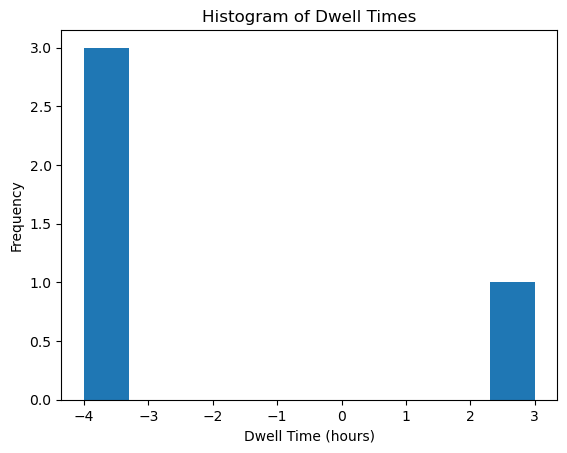

In [13]:
import matplotlib.pyplot as plt

# Assuming the DataFrame from the previous code is available
dwell_times = trips['dwell_time'].dt.total_seconds() / 3600  # Convert timedelta to hours

# Create histogram
plt.hist(dwell_times, bins=10)  # Adjust the number of bins as desired
plt.xlabel('Dwell Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Dwell Times')
plt.show()